# Base Line

In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction import _stop_words
import string
import nltk
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/leandrocorona/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/leandrocorona/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
data = pd.read_csv('top30.csv')
data['lenght']=data['content'].apply(len)
data=data.sort_values(by='lenght',ascending=False)[4:]
data = data[data['author']!='Breitbart News']
names = data.author.value_counts().index.tolist()
minarticles = data.author[data.author == names[-1]].value_counts()
#names.remove('Breitbart News')

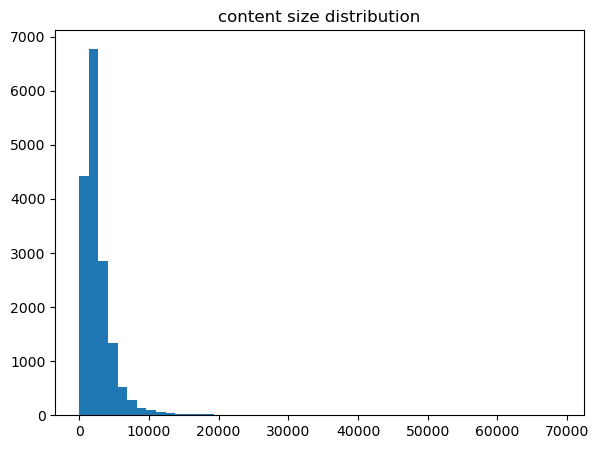

In [3]:
fig = plt.figure(figsize=(15, 5));
sub1 = plt.subplot(121)
plt.title("content size distribution") #Over all
data.lenght.hist( bins=50,grid=False);

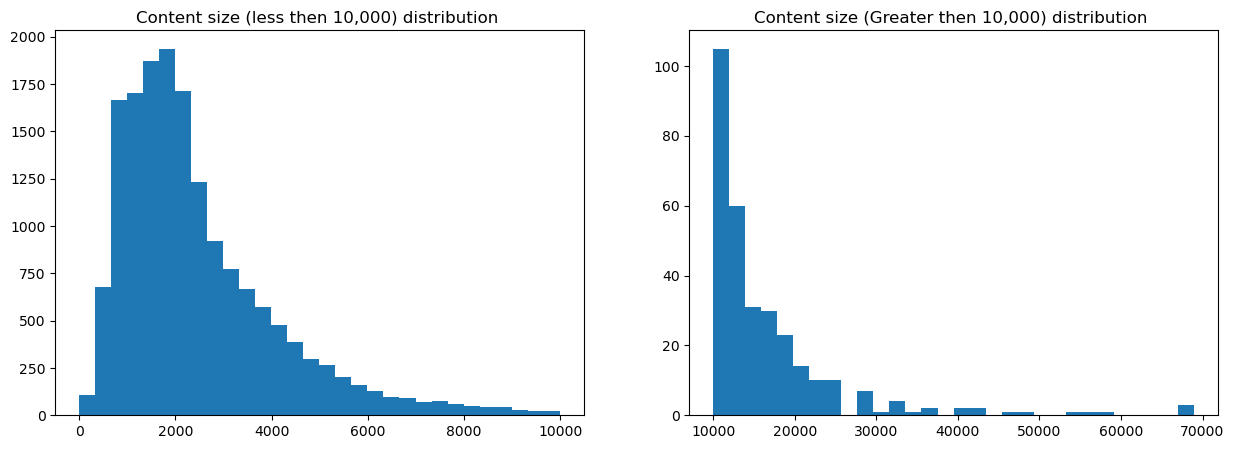

In [4]:
fig = plt.figure(figsize=(15, 5));
sub1 = plt.subplot(121)
plt.title("Content size (less then 10,000) distribution ") #Over all
data[data['lenght']<10000].lenght.hist(bins=30,grid=False);

sub2 = plt.subplot(122)
plt.title("Content size (Greater then 10,000) distribution ") #less then 10,000 text length
data[data['lenght']>10000].lenght.hist(bins=30,grid=False);

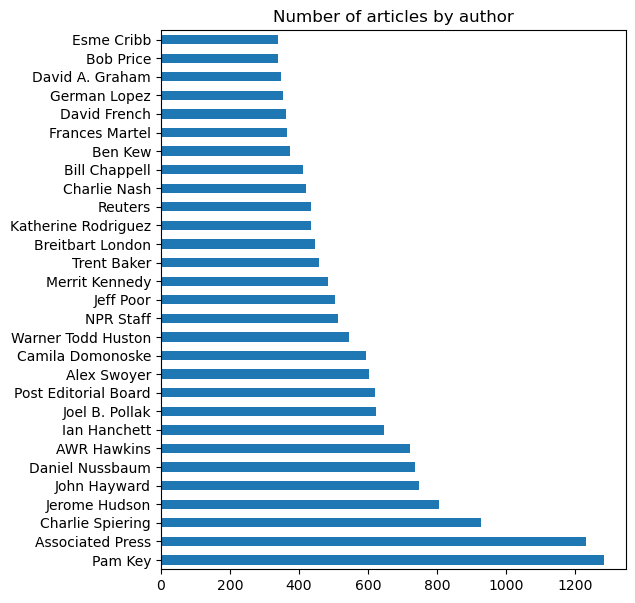

In [5]:
fig = plt.figure(figsize=(6, 7))
plt.title("Number of articles by author") 
data.author.value_counts().plot(kind='barh');

# Cleaning


In [6]:
import re
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
lemmatizer = WordNetLemmatizer()
Stop_Words= _stop_words.ENGLISH_STOP_WORDS

def text_processing(text):
    # Remove URL and its punctuation , and @
    text = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", text)
    
    # remove punctuation 
    text = "".join([c for c in text 
                    if c not in string.punctuation])
    # lowercase
    text = "".join([c.lower() for c in text])
    # remove stopwords
    text = " ".join([w for w in text.split() 
                     if w not in Stop_Words])
    # Stemming
    #stemmer = PorterStemmer()
    #text = " ".join([stemmer.stem(w1) for w1 in text.split()])
    
    # lematizing 
    text = " ".join([lemmatizer.lemmatize(w2) for w2 in text.split()])
    return text

In [7]:
data['clean_content'] = data['content'].apply(text_processing)

In [8]:
print("**Original content**\n",data[['content']].head(1).values[0][0][:830],"\n\n")

print("**Cleaned content**\n",data[['clean_content']].head(1).values[0][0][:500])

**Original content**
 MIGRANT CRISIS LIVE WIRE  —   This page will host all the relevant information from Europe’s unfolding migrant crisis. You can follow all the latest updates below. [This page is edited by Breitbart London’s Raheem Kassam, Chris Tomlinson, Oliver Lane and Donna Rachel Edmunds. Newest updates will appear at the top of the page.  *      *      *      *     * A 28 year old Romanian man is in the process fo being deported and banned from Denmark for six years after he was caught stealing two  . The man had already been ejected from Denmark once before for a previous offence, and so was in Denmark illegally before he was even caught stealing. The individual will likely serve a ten day prison sentence before being expelled, reports TheLocal. A 42 year old man was arrested last night on suspicion of murder after his girlfriend 


**Cleaned content**
 migrant crisis live wire page host relevant information europe unfolding migrant crisis follow latest update page edited br

> **Let's now represent the text in a format which can be used in machine learning**

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer()
bow_counts = count_vect.fit_transform(data['clean_content'].values)

In [10]:
print(len(count_vect.vocabulary_))

77552


In [11]:
from sklearn.feature_extraction.text import TfidfTransformer

tf_transformer = TfidfTransformer()
bow_tfidf = tf_transformer.fit_transform(bow_counts)

### 3. Classification

In [12]:
X_len = data['lenght'].values
X_len = X_len.reshape(-1, 1) # Since we it is single feature
X_bow_counts = bow_counts
X_bow_tfidf = bow_tfidf

author = list(data.author)
y = []
for index in author:
    ind = names.index(index)
    y.append(ind)

labels = np.array(names)

In [18]:
data['lenght'].values

array([68918, 68792, 66968, ...,    20,    13,     2])

In [13]:
print(X_len.shape)
print(X_bow_counts.shape)
print(X_bow_tfidf.shape)
print(len(y))

(16674, 1)
(16674, 77552)
(16674, 77552)
16674


80%/20% train/test split. Note that as the data is imbalanced, this split should be stratified, i.e., the proportion of spam messages in the test set should be the same as in the whole dataset.

In [94]:
# train/test split
from sklearn.model_selection import train_test_split

rs = 42 # reproducible results, set to None for random
(X_len_train, X_len_test, X_bow_counts_train, X_bow_counts_test, 
 X_bow_tfidf_train, X_bow_tfidf_test, y_train, y_test) = train_test_split(
    X_len, X_bow_counts, X_bow_tfidf, y,
    test_size=0.2, stratify=y, random_state=rs)

In [106]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1+1
        #print('Confusion matrix, without normalization')

    #print(cm)
    
    fig, ax = plt.subplots()
    #fig = plt.figure(figsize=(500, 200))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    #fig.tight_layout()
    plt.rcParams["figure.figsize"] = (28,16)
    return ax

**Classification using the message length only**

In [95]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

parameters = {'C': [10e-10, 0.1, 1, 10, 10e10]}
lr = GridSearchCV(LogisticRegression(class_weight='balanced', solver='lbfgs'), 
                  parameters, cv=5)
lr.fit(X_len_train, y_train)
print(lr.best_params_)

{'C': 1e-09}


                      precision    recall  f1-score   support

             Pam Key       0.00      0.00      0.00       256
    Associated Press       0.00      0.00      0.00       246
    Charlie Spiering       0.00      0.00      0.00       186
       Jerome Hudson       0.00      0.00      0.00       161
        John Hayward       0.00      0.00      0.00       149
     Daniel Nussbaum       0.00      0.00      0.00       147
         AWR Hawkins       0.00      0.00      0.00       144
        Ian Hanchett       0.00      0.00      0.00       129
      Joel B. Pollak       0.00      0.00      0.00       125
Post Editorial Board       0.00      0.00      0.00       124
         Alex Swoyer       0.00      0.00      0.00       121
    Camila Domonoske       0.00      0.00      0.00       119
  Warner Todd Huston       0.00      0.00      0.00       109
           NPR Staff       0.00      0.00      0.00       103
           Jeff Poor       0.00      0.00      0.00       101
      M

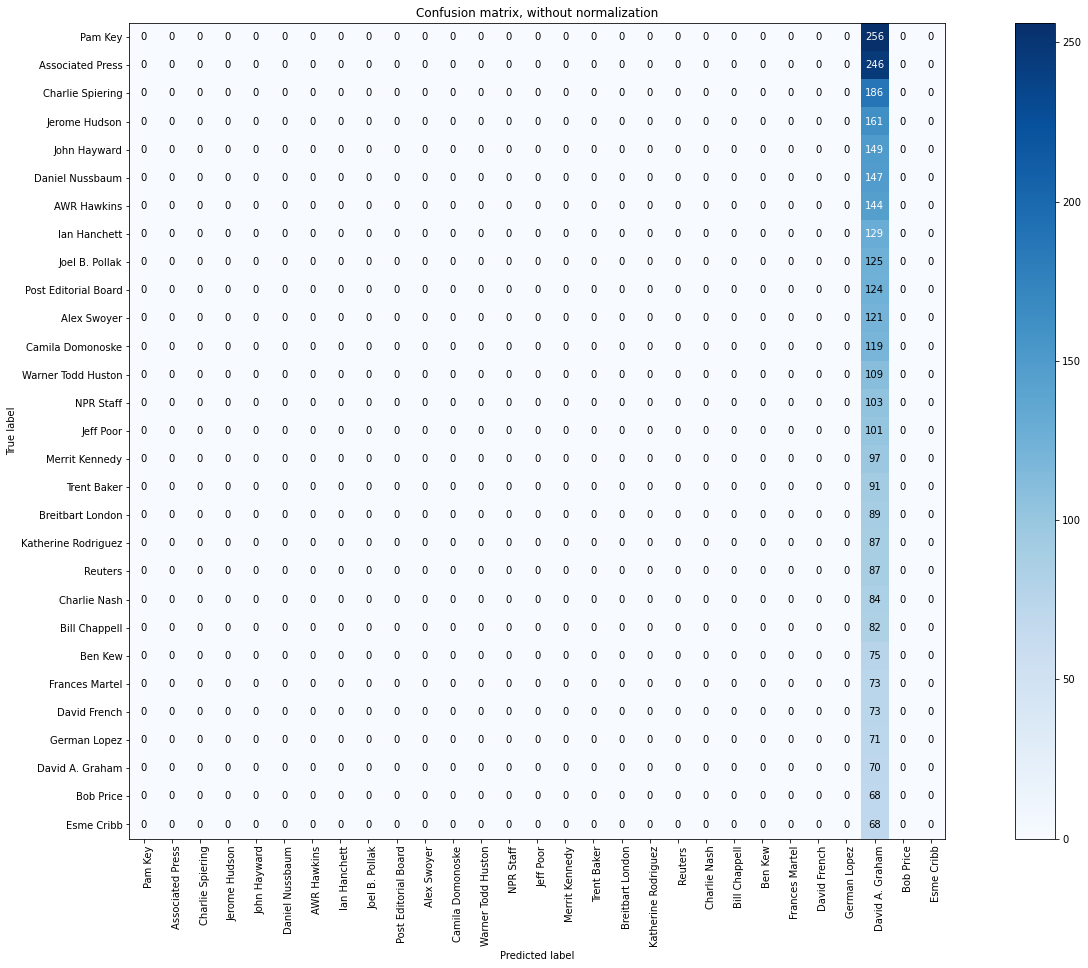

In [107]:
from sklearn.metrics import classification_report
y_pred = lr.predict(X_len_test)
print(classification_report(y_test, y_pred, target_names=labels))
plot_confusion_matrix(y_test, y_pred, labels)
plt.show()

**Classification using tf-idf matrix**

In [108]:
parameters = {'C': [10e-10, 0.1, 1, 10, 10e10]}
lr = GridSearchCV(LogisticRegression(class_weight='balanced', solver='lbfgs'), 
                  parameters, cv=5)
lr.fit(X_bow_tfidf_train, y_train)
print(lr.best_params_)

{'C': 10}


                      precision    recall  f1-score   support

             Pam Key       0.99      0.95      0.97       256
    Associated Press       0.65      0.74      0.69       246
    Charlie Spiering       0.83      0.88      0.85       186
       Jerome Hudson       0.94      0.94      0.94       161
        John Hayward       0.82      0.76      0.79       149
     Daniel Nussbaum       0.90      0.96      0.93       147
         AWR Hawkins       0.99      0.99      0.99       144
        Ian Hanchett       0.99      0.98      0.99       129
      Joel B. Pollak       0.98      0.84      0.91       125
Post Editorial Board       0.89      0.88      0.89       124
         Alex Swoyer       0.84      0.90      0.87       121
    Camila Domonoske       0.66      0.61      0.64       119
  Warner Todd Huston       0.99      0.96      0.98       109
           NPR Staff       0.74      0.82      0.77       103
           Jeff Poor       1.00      0.97      0.98       101
      M

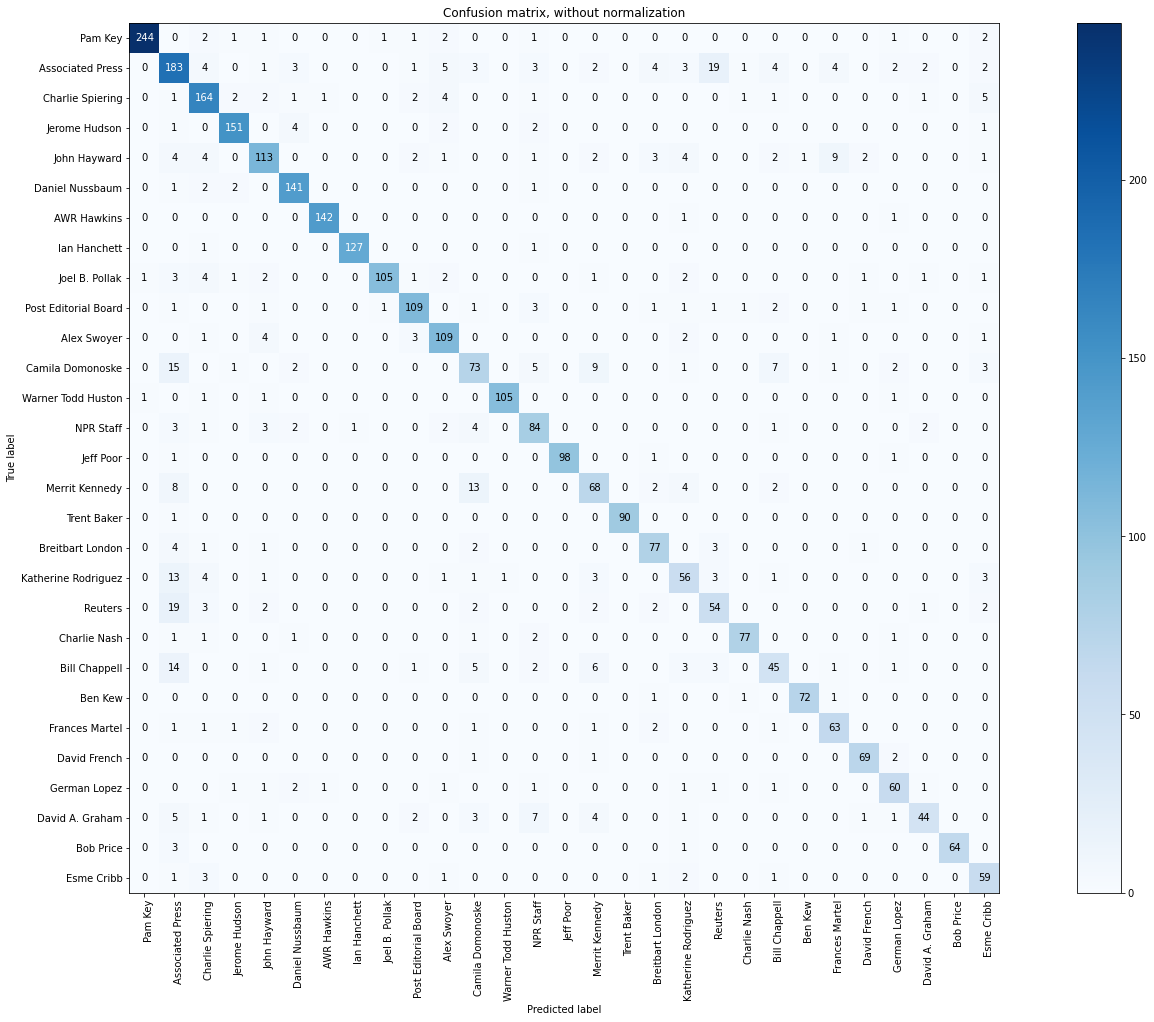

In [109]:
y_pred = lr.predict(X_bow_tfidf_test)
print(classification_report(y_test, y_pred, target_names=labels))
plot_confusion_matrix(y_test, y_pred, labels)
plt.show()

**Classification using term frequencies (counts)**

In [110]:
parameters = {'C': [10e-10, 0.1, 1, 10, 10e10]}
lr = GridSearchCV(LogisticRegression(class_weight='balanced', solver='lbfgs'), 
                  parameters, cv=5)
lr.fit(X_bow_counts_train, y_train)
print(lr.best_params_)

{'C': 0.1}


                      precision    recall  f1-score   support

             Pam Key       0.98      0.96      0.97       256
    Associated Press       0.67      0.71      0.69       246
    Charlie Spiering       0.79      0.89      0.84       186
       Jerome Hudson       0.96      0.97      0.97       161
        John Hayward       0.83      0.74      0.78       149
     Daniel Nussbaum       0.94      0.96      0.95       147
         AWR Hawkins       0.99      0.98      0.99       144
        Ian Hanchett       1.00      1.00      1.00       129
      Joel B. Pollak       0.91      0.85      0.88       125
Post Editorial Board       0.82      0.91      0.87       124
         Alex Swoyer       0.81      0.95      0.87       121
    Camila Domonoske       0.66      0.56      0.61       119
  Warner Todd Huston       1.00      0.98      0.99       109
           NPR Staff       0.86      0.86      0.86       103
           Jeff Poor       0.99      0.99      0.99       101
      M

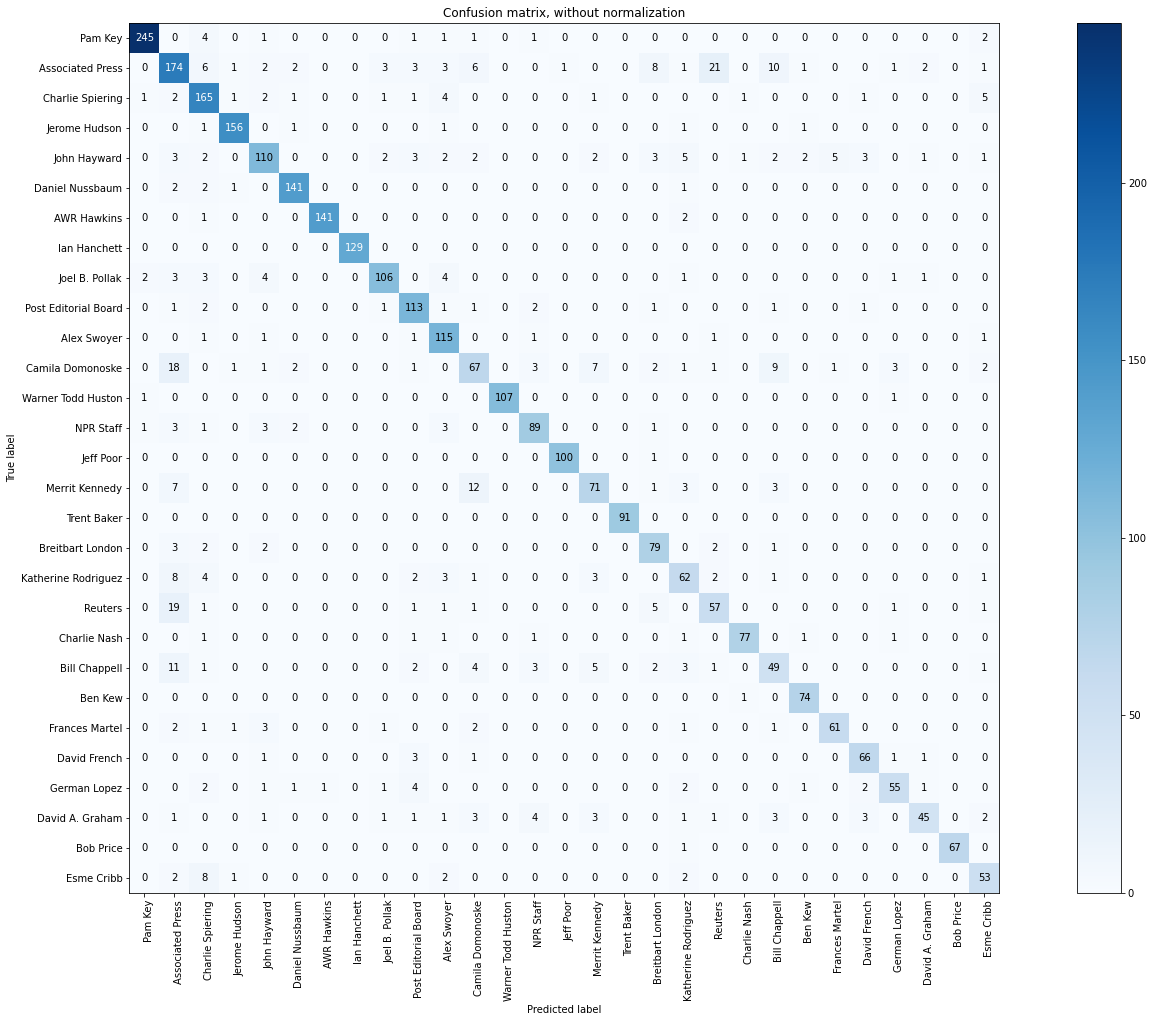

In [111]:
y_pred = lr.predict(X_bow_counts_test)
print(classification_report(y_test, y_pred, target_names=labels))
plot_confusion_matrix(y_test, y_pred, labels)
plt.show()